<a href="https://colab.research.google.com/github/muhibuddin12/ML-SK_learn/blob/main/LearnPyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=aaca13bfba814f358f8acb999f82dc6a85e8fc6402dd7e829df07626f6aa3e8b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession

## Step 1: Creating a SparkSession

In [4]:
spark = SparkSession.builder.appName("Datacamp Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

## Step 2: Creating the DataFrame

The dataframe consists of 8 variables:
1. InvoiceNo: The unique identifier of each customer invoice.
2. StockCode: The unique identifier of each item in stock.
3. Description: The item purchased by the customer.
4. Quantity: The number of each item purchased by a customer in a single invoice.
5. InvoiceDate: The purchase date.
6. UnitPrice: Price of one unit of each item.
7. CustomerID: Unique identifier assigned to each user.
8. Country: The country from where the purchase was made

In [5]:
df = spark.read.csv('datacamp_ecommerce.csv',header=True,escape="\"")

In [6]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+--------+------

In [7]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



## Step 3: Exploratory Data Analysis

In [8]:
#Let’s start by counting the number of rows in the dataframe:
df.count()

541909

In [9]:
#How many unique customers are present in the dataframe?
df.select('CustomerID').distinct().count()

4373

In [10]:
#What country do most purchases come from?
from pyspark.sql.functions import *
from pyspark.sql.types import *

df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [11]:
#When was the most recent purchase made by a customer on the e-commerce platform?
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',when(
        to_timestamp(col("InvoiceDate"), 'yy/MM/dd HH:mm') >= '2011-01-01 00:00:00',
        to_timestamp(col("InvoiceDate"), 'yy/MM/dd HH:mm')
    ).when(
        date_format(to_timestamp(col("InvoiceDate"), 'yy/dd/MM HH:mm'), 'yyyy-MM-dd HH:mm:ss') >= '2011-01-01 00:00:00',
        date_format(to_timestamp(col("InvoiceDate"), 'yy/dd/MM HH:mm'), 'yyyy-MM-dd HH:mm:ss')
    ).when(
        date_format(to_timestamp(col("InvoiceDate"), 'MM/dd/yy HH:mm'), 'yyyy-MM-dd HH:mm:ss') >= '2011-01-01 00:00:00',
        date_format(to_timestamp(col("InvoiceDate"), 'MM/dd/yy HH:mm'), 'yyyy-MM-dd HH:mm:ss')
    ).otherwise(
        date_format(to_timestamp(col("InvoiceDate"), 'dd/MM/yy HH:mm'), 'yyyy-MM-dd HH:mm:ss')
    ))
# df.select(max("date")).show()
df.describe().show()

+-------+------------------+------------------+--------------------+------------------+-------------+-----------------+------------------+-----------+-------------------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|  InvoiceDate|        UnitPrice|        CustomerID|    Country|               date|
+-------+------------------+------------------+--------------------+------------------+-------------+-----------------+------------------+-----------+-------------------+
|  count|            541909|            541909|              540455|            541909|       541909|           541909|            406829|     541909|             541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0|  9.55224954743324|         NULL|4.611113626082947|15287.690570239585|       NULL|               NULL|
| stddev|13428.417280800071| 16799.73762842768|                NULL|218.08115785023472|         NULL|96.75985306117954|1713.6003033215868|       

In [12]:
#When was the earliest purchase made by a customer on the e-commerce platform?
# df.select(min("date")).show()
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: string (nullable = true)



## Step 4: Data Pre-processing

In [13]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEA

### Recency

First, let’s calculate the value of recency - the latest date and time a purchase was made on the platform. This can be achieved in two steps:

In [14]:
 # i) Assign a recency score to each customer

df = df.withColumn("from_date", lit("12/12/10 16:21"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))
df = df.withColumn('date', to_timestamp(col('date'), 'yyyy-MM-dd HH:mm:ss'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))
# df2.orderBy(asc("recency")).show()
df2.count()

541909

In [15]:
# ii) Select the most recent purchase

df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')
df2.count()

93257

In [16]:
df2.show()
# df2.groupBy('CustomerID').agg(max('recency').alias('recency')).count()


+---------+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|  recency|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|               date|          from_date|
+---------+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|-28971960|   536369|    21756|BATH BUILDING BLO...|       3|12/1/10 8:35|     5.95|     13047|United Kingdom|2012-01-10 08:35:00|2012-12-10 16:21:00|
|-28970460|   536371|    22086|PAPER CHAIN KIT 5...|      80|12/1/10 9:00|     2.55|     13748|United Kingdom|2012-01-10 09:00:00|2012-12-10 16:21:00|
|-28967760|   536382|    10002|INFLATABLE POLITI...|      12|12/1/10 9:45|     0.85|     16098|United Kingdom|2012-01-10 09:45:00|2012-12-10 16:21:00|
|-28967760|   536382|    21912|VINTAGE SNAKES & ...|       8|12/1/10 9:45|     3.75|     16098

In [18]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



### Frequency

Let’s now calculate the value of frequency - how often a customer bought something on the platform. To do this, we just need to group by each customer ID and count the number of items they purchased:

In [19]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [20]:
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|16250     |14       |
|15271     |24       |
|15555     |26       |
|15574     |1        |
|17714     |10       |
+----------+---------+
only showing top 5 rows



In [21]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')
df3.count()

90941

In [22]:
df3.show(5,0)

+----------+---------+---------+---------+-------------------------------+--------+------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|recency  |InvoiceNo|StockCode|Description                    |Quantity|InvoiceDate |UnitPrice|Country       |date               |from_date          |frequency|
+----------+---------+---------+---------+-------------------------------+--------+------------+---------+--------------+-------------------+-------------------+---------+
|13047     |-28971960|536369   |21756    |BATH BUILDING BLOCK WORD       |3       |12/1/10 8:35|5.95     |United Kingdom|2012-01-10 08:35:00|2012-12-10 16:21:00|1        |
|13748     |-28970460|536371   |22086    |PAPER CHAIN KIT 50'S CHRISTMAS |80      |12/1/10 9:00|2.55     |United Kingdom|2012-01-10 09:00:00|2012-12-10 16:21:00|1        |
|16098     |-28967760|536382   |10002    |INFLATABLE POLITICAL GLOBE     |12      |12/1/10 9:45|0.85     |United Kingdom|2012-01-10 09:45:00

In [23]:
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



### Monetary Value
Finally, let’s calculate monetary value - the total amount spent by each customer in the dataframe. There are two steps to achieving this:

In [24]:
#i) Find the total amount spent in each purchase:

m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

In [25]:
#ii) Find the total amount spent by each customer:

m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [26]:
#Merge this dataframe with the all the other variables:

finaldf = m_val.join(df3,on='CustomerID',how='inner')

In [27]:
#Now that we have created all the necessary variables to build the model,
#run the following lines of code to select only the required columns and drop duplicate rows from the dataframe:

finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()
finaldf.show()

+---------+---------+-------------------+----------+
|  recency|frequency|     monetary_value|CustomerID|
+---------+---------+-------------------+----------+
|-28966920|       14|             226.14|     16250|
| -7871640|       24|             111.75|     15271|
| -5025300|       26| 171.03999999999996|     15555|
| -4764780|        1|               3.75|     15574|
|-59377740|       10|              153.0|     17714|
|-46572960|        9| 185.78000000000003|     16320|
| -4933140|       61|  652.6099999999999|     17757|
| -4846140|       43|             306.84|     17551|
|-60816240|       37| 236.01999999999995|     13187|
|-59272140|       30|             215.78|     15052|
|-58685940|       28| 494.64000000000004|     15448|
|-50199540|        1|              81.36|     12888|
|-43996320|        1|              -3.95|     17866|
| -5006460|       20|              462.3|     14525|
|-54196740|        1|               27.0|     12811|
|-53582460|        2|              -21.8|     

### Standardization

Before building the customer segmentation model, let’s standardize the dataframe to ensure that all the variables are around the same scale:

In [28]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [29]:
data_scale_output.select('standardized').show(2,truncate=False)

+-----------------------------------------------------------+
|standardized                                               |
+-----------------------------------------------------------+
|[-1.8830826995296401,0.390452625165827,0.08017005995483929]|
|[-0.5117198894782565,0.669347357427132,0.03961706995645747]|
+-----------------------------------------------------------+
only showing top 2 rows



## Step 5: Building the Machine Learning Model

### i) Finding the number of clusters to use
When building a K-Means clustering model, we first need to determine the number of clusters or groups we want the algorithm to return. If we decide on three clusters, for instance, then we will have three customer segments.

The most popular technique used to decide on how many clusters to use in K-Means is called the “elbow-method.”

This is done simply running the K-Means algorithm for a wide range of clusters and visualizing the model results for each cluster. The plot will have an inflection point that looks like an elbow, and we just pick the number of clusters at this point.

Read this Datacamp K-Means clustering tutorial to learn more about how the algorithm works.

Let’s run the following lines of code to build a K-Means clustering algorithm from 2 to 10 clusters:

In [30]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

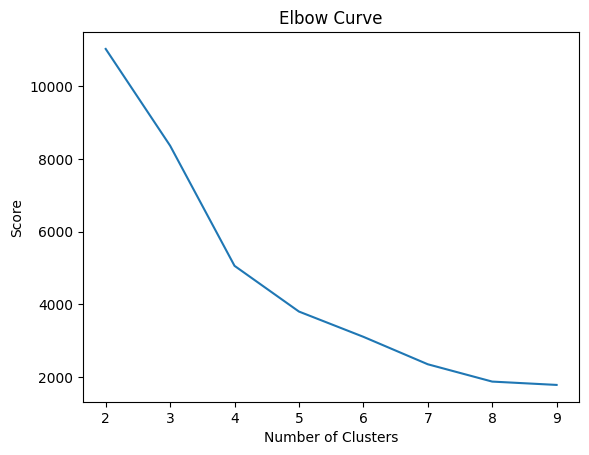

In [31]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

### ii) Building the K-Means Clustering Model

From the plot above, we can see that there is an inflection point that looks like an elbow at four. Due to this, we will proceed to build the K-Means algorithm with four clusters:

In [32]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

### iii) Making Predictions
Let’s use the model we created to assign clusters to each customer in the dataset:

In [33]:
preds = KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+---------+---------+------------------+----------+------------------------------------+-------------------------------------------------------------+----------+
|recency  |frequency|monetary_value    |CustomerID|features                            |standardized                                                 |prediction|
+---------+---------+------------------+----------+------------------------------------+-------------------------------------------------------------+----------+
|-28966920|14       |226.14            |16250     |[-2.896692E7,14.0,226.14]           |[-1.8830826995296401,0.390452625165827,0.08017005995483929]  |1         |
|-7871640 |24       |111.75            |15271     |[-7871640.0,24.0,111.75]            |[-0.5117198894782565,0.669347357427132,0.03961706995645747]  |2         |
|-5025300 |26       |171.03999999999996|15555     |[-5025300.0,26.0,171.03999999999996]|[-0.3266849043649204,0.725126303879393,0.06063627423134213]  |2         |
|-4764780 |1        |3.75   

## Step 6: Cluster Analysis

The final step in this entire tutorial is to analyze the customer segments we just built.

Run the following lines of code to visualize the recency, frequency, and monetary value of each customerID in the dataframe:

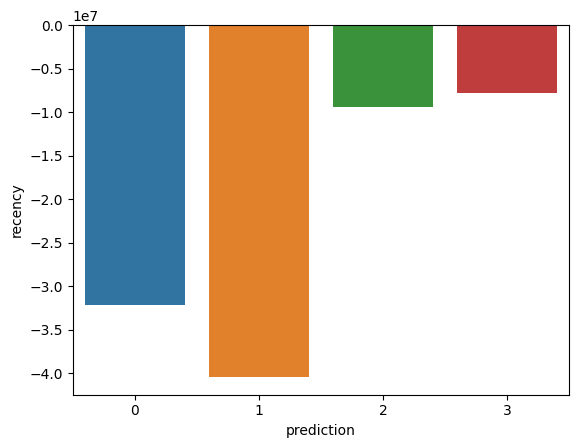

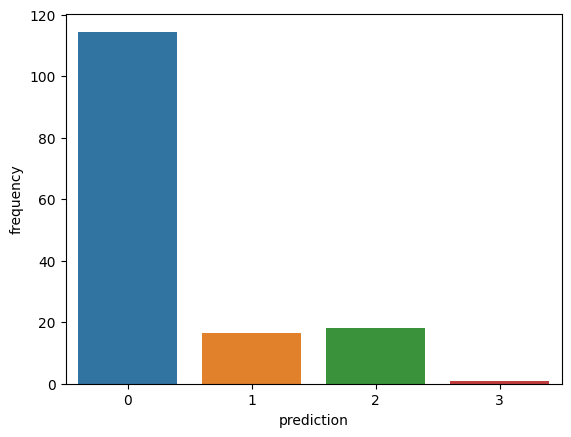

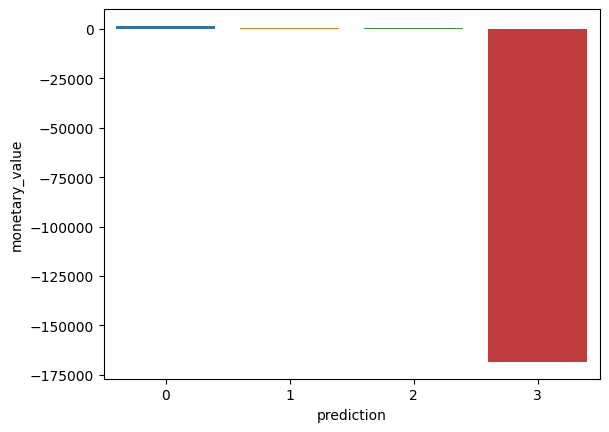

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

Here is an overview of characteristics displayed by customers in each cluster:

1. Cluster 0: Customers in this segment display low recency, frequency, and monetary value. They rarely shop on the platform and are low potential customers who are likely to stop doing business with the ecommerce company.
2. Cluster 1: Users in this cluster display high recency but haven’t been seen spending much on the platform. They also don’t visit the site often. This indicates  that they might be newer customers who have just started doing business with the company.
3. Cluster 2: Customers in this segment display medium recency and frequency and spend a lot of money on the platform. This indicates that they tend to buy high-value items or make bulk purchases.
4. Cluster 3: The final segment comprises users who display high recency and make frequent purchases on the platform. However, they don’t spend much on the platform, which might mean that they tend to select cheaper items in each purchase.